**Tugas Kecerdasan Buatan Week 12 CNN\
Muhammad Aulia Bahtiar\
NIM. 122430062**

**Langkah 1.** Set Path Dataset

Pada langkah ini, kita menentukan lokasi folder dataset yang berisi gambar digit 0-9. Dataset harus memiliki struktur folder dimana setiap subfolder merepresentasikan satu kelas (0, 1, 2, ..., 9).

**Struktur folder:**
```
digits updated/
    ├── 0/  (gambar digit 0)
    ├── 1/  (gambar digit 1)
    ├── 2/  (gambar digit 2)
    ...
    └── 9/  (gambar digit 9)
```

Pastikan path sesuai dengan lokasi dataset di komputer Anda.

In [1]:
data_path = r"c:\Users\muham\Downloads\Kecerdasan Buatan BM (Augmentasi Citra Medis Week 10)\Folder AI Week 12\DIGITS DATASET\digits updated"

**Langkah 2.** Load Dataset (Training & Validation)

Memuat dataset dari folder menggunakan `image_dataset_from_directory`. Dataset akan otomatis dibagi menjadi:
- **80% untuk Training** - digunakan untuk melatih model
- **20% untuk Validation** - digunakan untuk evaluasi performa

**Parameter penting:**
- `image_size=(28, 28)` - semua gambar diresize menjadi 28x28 pixel
- `color_mode="grayscale"` - gambar dikonversi ke grayscale (1 channel)
- `batch_size=32` - data diproses dalam batch 32 gambar
- `seed=42` - untuk hasil yang konsisten/reproducible

Kita juga menyimpan `class_names` sebelum preprocessing karena akan hilang setelah operasi cache/prefetch.

In [2]:
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(28, 28),
    color_mode="grayscale",
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(28, 28),
    color_mode="grayscale",
    batch_size=32
)

# Store class names before prefetching
class_names = train_ds.class_names

Found 10160 files belonging to 10 classes.
Using 8128 files for training.
Using 8128 files for training.
Found 10160 files belonging to 10 classes.
Using 2032 files for validation.
Found 10160 files belonging to 10 classes.
Using 2032 files for validation.


print("Class names:", train_ds.class_names)

**Langkah 3.** Normalisasi Dataset

Normalisasi adalah proses mengubah nilai pixel dari range **0-255** menjadi **0-1** dengan membagi setiap pixel dengan 255.0.

**Mengapa perlu normalisasi?**
- Model neural network bekerja lebih baik dengan nilai yang kecil
- Mempercepat proses training
- Mencegah gradient exploding/vanishing
- Meningkatkan stabilitas pembelajaran

Setelah normalisasi, pixel value yang tadinya 255 (putih) menjadi 1.0, dan 0 (hitam) tetap 0.

In [3]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

**Langkah 4.** Bangun Model CNN Sederhana

Membuat arsitektur Convolutional Neural Network (CNN) dengan struktur berikut:

**Layer 1-2: Feature Extraction**
- `Conv2D(32)` - 32 filter untuk mendeteksi pola dasar (edges, curves)
- `MaxPooling2D` - mereduksi ukuran spatial, ambil fitur penting
- `Conv2D(64)` - 64 filter untuk pola kompleks
- `MaxPooling2D` - reduksi dimensi lagi

**Layer 3-5: Classification**
- `Flatten` - ubah 2D menjadi 1D vector
- `Dense(128)` - fully connected layer, 128 neurons
- `Dense(10)` - output layer, 10 neurons (digit 0-9)

**Activation function:**
- `relu` - untuk hidden layers (mengatasi negative values)
- `softmax` - untuk output layer (memberikan probabilitas per kelas)

Total parameters: ~50,000

In [4]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

c:\Users\muham\AppData\Local\Python\pythoncore-3.11-64\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

**Langkah 5.** Kompilasi Model

Compile model dengan menentukan komponen penting untuk training:

**1. Optimizer: `adam`**
- Algoritma optimasi yang adaptive (menyesuaikan learning rate)
- Cocok untuk berbagai jenis problem
- Menggabungkan momentum dan adaptive learning rate

**2. Loss Function: `sparse_categorical_crossentropy`**
- Untuk klasifikasi multi-class (10 kelas: 0-9)
- `sparse` karena label berupa integer (0,1,2...), bukan one-hot encoded
- Mengukur seberapa jauh prediksi dari label sebenarnya

**3. Metrics: `accuracy`**
- Mengukur persentase prediksi yang benar
- Mudah diinterpretasi (contoh: 85% berarti 85 dari 100 prediksi benar)

In [5]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Langkah 6.** Training Model

Melatih model dengan data training yang sudah dioptimasi menggunakan:

**Optimasi Data Loading:**
- `cache()` - menyimpan data di memory, tidak perlu load ulang setiap epoch
- `prefetch(AUTOTUNE)` - load data batch berikutnya saat training batch sekarang
- Mempercepat training hingga 2-3x lebih cepat!

**Early Stopping:**
- Monitoring `val_loss` (validation loss)
- `patience=3` - stop jika val_loss tidak turun selama 3 epoch berturut-turut
- `restore_best_weights=True` - gunakan model terbaik, bukan yang terakhir
- Mencegah overfitting (model terlalu "hafal" data training)

**Training Settings:**
- `epochs=5` - maksimal 5 epoch (bisa berhenti lebih awal jika early stopping triggered)
- Waktu training: ~2-3 menit

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8948 - loss: 0.3942 - val_accuracy: 0.9803 - val_loss: 0.0771
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8948 - loss: 0.3942 - val_accuracy: 0.9803 - val_loss: 0.0771
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9825 - loss: 0.0569 - val_accuracy: 0.9872 - val_loss: 0.0424
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9825 - loss: 0.0569 - val_accuracy: 0.9872 - val_loss: 0.0424
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9905 - loss: 0.0320 - val_accuracy: 0.9882 - val_loss: 0.0359
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9905 - loss: 0.0320 - val_accuracy: 0.9882 - val_loss: 0.0359
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9953 - loss: 0.0154 - val_accuracy: 0.9902 - val_loss: 0.0268
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9953 - loss: 0.0154 - val_accuracy: 0.9902 -

**Langkah 7.** Evaluasi Model

Menguji performa model menggunakan validation dataset (data yang tidak digunakan saat training).

**Metrics yang diukur:**
- **Loss** - seberapa besar error model (semakin kecil semakin baik)
- **Accuracy** - persentase prediksi yang benar (target: >85%)

Validation accuracy menunjukkan seberapa baik model dapat memprediksi data yang belum pernah dilihat sebelumnya. Ini adalah indikator sesungguhnya dari performa model.

In [7]:
test_loss, test_acc = model.evaluate(val_ds)
print("\n" + "="*60)
print("📊 HASIL EVALUASI MODEL")
print("="*60)
print(f"Validation Loss: {test_loss:.4f}")
print(f"Validation Accuracy: {test_acc*100:.2f}%")
print("="*60)

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0206

📊 HASIL EVALUASI MODEL
Validation Loss: 0.0206
Validation Accuracy: 99.31%
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0206

📊 HASIL EVALUASI MODEL
Validation Loss: 0.0206
Validation Accuracy: 99.31%


**Langkah 8.** Prediksi Gambar

Menampilkan 5 sample gambar dari validation set dengan prediksi model.

**Informasi yang ditampilkan:**
- **True** - label sebenarnya
- **Pred** - prediksi model
- **Confidence** - tingkat kepercayaan model (0-100%)

**Color coding:**
- 🟢 **Hijau** = Prediksi benar (True = Pred)
- 🔴 **Merah** = Prediksi salah (True ≠ Pred)

Ini membantu kita melihat secara visual apakah model bisa membedakan digit dengan baik atau sering salah prediksi.

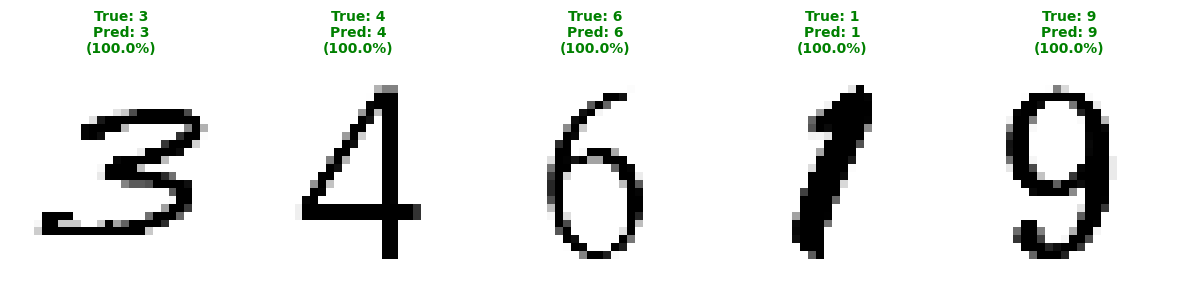

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

for images, labels in val_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        
        img = images[i]
        true_label = class_names[labels[i].numpy()]
        
        plt.imshow(img.numpy().reshape(28,28), cmap='gray')
        plt.axis('off')
        
        img_expanded = tf.expand_dims(img, axis=0)
        pred = model.predict(img_expanded, verbose=0)
        predicted_class = class_names[tf.argmax(pred[0]).numpy()]
        confidence = tf.reduce_max(pred[0]).numpy() * 100
        
        color = 'green' if true_label == predicted_class else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_class}\n({confidence:.1f}%)",
                 color=color, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Langkah 9.** Plot Grafik Akurasi dan Loss

Visualisasi learning curve untuk memahami proses training:

**Grafik Accuracy (kiri):**
- **Training Accuracy** (biru) - performa di data training
- **Validation Accuracy** (merah) - performa di data validation
- Idealnya kedua line naik bersamaan

**Grafik Loss (kanan):**
- **Training Loss** (biru) - error di data training
- **Validation Loss** (merah) - error di data validation
- Idealnya kedua line turun bersamaan

**Interpretasi:**
- Jika val_acc jauh lebih rendah dari train_acc → **Overfitting** (model hafal data)
- Jika kedua line dekat → **Good fit** (model generalisasi baik)
- Jika val_loss naik saat train_loss turun → Early stopping akan stop training

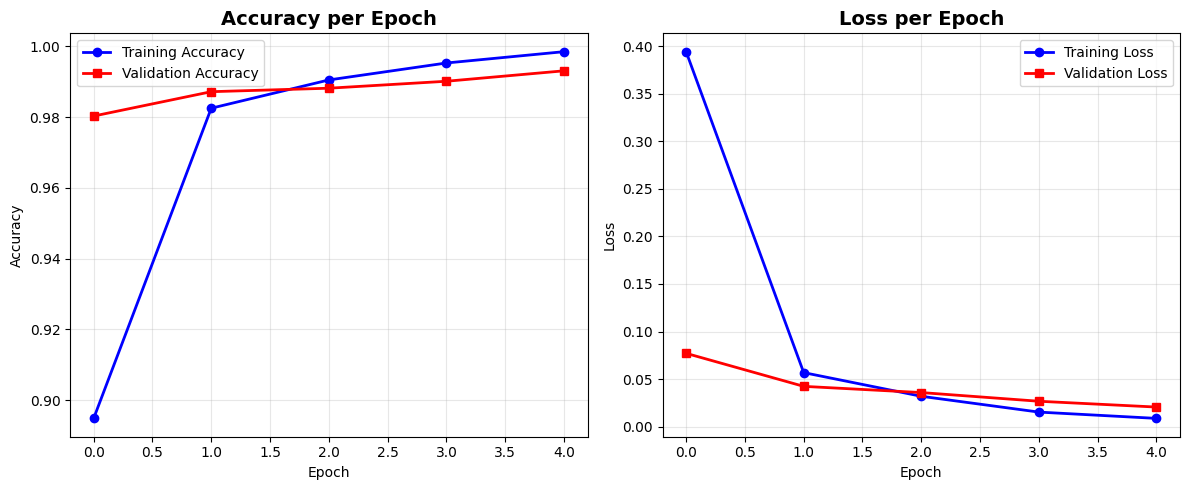


📈 HASIL AKHIR TRAINING
Training Accuracy: 99.85%
Validation Accuracy: 99.31%
Training Loss: 0.0088
Validation Loss: 0.0206


In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'b-', marker='o', linewidth=2, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', marker='s', linewidth=2, label='Validation Accuracy')
plt.title('Accuracy per Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'b-', marker='o', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', marker='s', linewidth=2, label='Validation Loss')
plt.title('Loss per Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tampilkan hasil akhir
print("\n" + "="*60)
print("📈 HASIL AKHIR TRAINING")
print("="*60)
print(f"Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("="*60)

**Langkah 10.** Confusion Matrix

Confusion matrix adalah tabel yang menunjukkan detail prediksi model untuk setiap kelas.

**Cara membaca:**
- **Baris** = Label sebenarnya (True)
- **Kolom** = Prediksi model (Predicted)
- **Diagonal** (kiri atas ke kanan bawah) = Prediksi benar
- **Angka di luar diagonal** = Prediksi salah

**Contoh interpretasi:**
- Jika baris "8" kolom "3" ada angka 5 → model salah prediksi 5 gambar digit 8 sebagai digit 3
- Semakin gelap warna di diagonal → semakin banyak prediksi benar untuk kelas tersebut

Confusion matrix membantu menemukan kelas mana yang sering salah diprediksi (contoh: digit 8 sering diprediksi sebagai 3 atau 6).

Mengumpulkan prediksi...


<Figure size 1000x800 with 0 Axes>

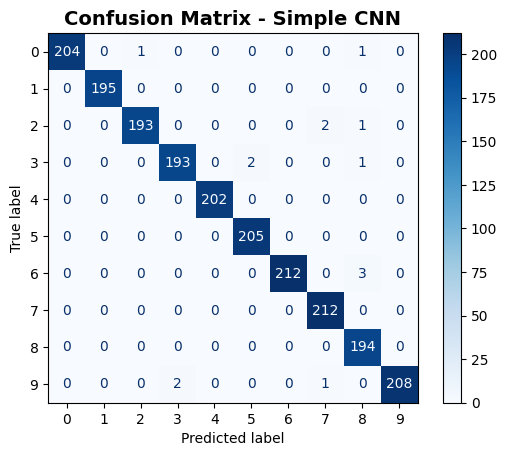


🎯 HASIL CONFUSION MATRIX
Total Prediksi: 2032
Prediksi Benar: 2018
Prediksi Salah: 14
Akurasi: 99.31%


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

print("Mengumpulkan prediksi...")
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds = tf.argmax(preds, axis=1).numpy()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Simple CNN", fontsize=14, fontweight='bold')
plt.show()

# Hitung dan tampilkan akurasi dari confusion matrix
accuracy = np.sum(y_true == y_pred) / len(y_true) * 100
print("\n" + "="*60)
print("🎯 HASIL CONFUSION MATRIX")
print("="*60)
print(f"Total Prediksi: {len(y_true)}")
print(f"Prediksi Benar: {np.sum(y_true == y_pred)}")
print(f"Prediksi Salah: {np.sum(y_true != y_pred)}")
print(f"Akurasi: {accuracy:.2f}%")
print("="*60)

**Langkah 11.** Save Model

Menyimpan model yang sudah ditraining ke file `.h5` (format HDF5).

**Mengapa perlu save model?**
- Tidak perlu training ulang (hemat waktu dan resource)
- Bisa digunakan untuk prediksi data baru
- Bisa di-deploy ke aplikasi/website
- Bisa dishare ke orang lain

**File yang disimpan:**
- Architecture model (struktur layer)
- Weights (parameter yang sudah ditraining)
- Optimizer state
- Training configuration

**Cara load model nanti:**
```python
from tensorflow.keras.models import load_model
model = load_model("simple_cnn_model.h5")
```

File size: ~200KB (sangat ringan!)

In [11]:
import os

model.save("simple_cnn_model.h5")

print("\n" + "="*60)
print("💾 MODEL BERHASIL DISIMPAN!")
print("="*60)
print(f"Nama File: simple_cnn_model.h5")
print(f"Lokasi: {os.path.abspath('simple_cnn_model.h5')}")
print(f"Ukuran File: {os.path.getsize('simple_cnn_model.h5') / 1024:.2f} KB")
print(f"\nPerforma Model:")
print(f"  - Validation Accuracy: {test_acc*100:.2f}%")
print(f"  - Validation Loss: {test_loss:.4f}")
print("="*60)


💾 MODEL BERHASIL DISIMPAN!
Nama File: simple_cnn_model.h5
Lokasi: c:\Users\muham\Downloads\Kecerdasan Buatan BM (Augmentasi Citra Medis Week 10)\Folder AI Week 12\simple_cnn_model.h5
Ukuran File: 2677.44 KB

Performa Model:
  - Validation Accuracy: 99.31%
  - Validation Loss: 0.0206
